In [72]:
import albumentations as A
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

List of usefull augmentations:

HorizontalFlip	
PixelDropout - Set pixels to 0 with some probability.
RandomScale	- Randomly resize the input. Output image size is different from the input image size.
Rotate	- Rotate the input by an angle selected randomly from the uniform distribution.
Scale - Randomly apply scale

RandomBrightnessContrast 
GaussianBlur (mabey)

In [74]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate (limit=30, interpolation=1, border_mode=4, p=0.5),
    A.RandomScale (scale_limit=0.2, p=0.5) 
], bbox_params=A.BboxParams(format='yolo' , min_visibility=0.1 , label_fields=['class_labels']))

In [119]:
path_lables = './processed_data/train/labels/'
path_images = './processed_data/train/images/'

images = os.listdir('./processed_data/train/images')
lables = os.listdir('./processed_data/train/labels')

# Get file name without the extension
def filename(path):
    file = os.path.splitext(path)[0]
    return file

img_arr = [] # Data images
bboxes = [] # Bounding Boxes
class_labels = [] # Class names
filename_arr = []


# Place image and labels data into arrays
for label in lables:
    for image in images:
        if filename(label) == filename(image):
            
            # Read the img into numpy arr
            img = cv2.imread(path_images + image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_arr.append(img)
            filename_arr.append(filename(label))
            
            with open(path_lables+label) as f:
                for line in f:
                    data = line.split()
                    temp = []
#                     label_data = int(data[0])
                    bounding_box = np.array(data[1:]).astype(float)
                    class_labels.append([data[0]])
                    bounding_box = bounding_box.tolist()
                    bboxes.append([bounding_box])

# print(bboxes[0])
# print(filename_arr[0])

# test if all the data was inserted into the arrays
print(len(bboxes)) 
print(len(class_labels))
print(len(img_arr))
print(len(filename_arr))

72
72
72
72


In [120]:
# Function to convert bounding boxes in YOLO format
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

# Draw augmented boxes round the new image
def draw_boxes(image, bboxes):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    box_areas = []
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=2
        ) 
        box_areas.append(width*height) 
        
    return image, box_areas

In [121]:
# Saves images and lables to correct folders
def save_data(data_path,filename , img , txt , label):
    
    file_path = data_path+ "/labels/" + filename + ".txt"
    
    with open(file_path, 'w') as f:
        f.write(str(label[0]))
        for value in txt:
            f.write(' ')
            f.write(str(value))
    
    
    # Save the image
    cv2.imwrite(data_path+ "/images/" + filename + ".jpg", img)

In [122]:
for i in range(len(img_arr)):
    for j in range (10):
        transformed = transform(
                image=img_arr[i], bboxes=bboxes[i], class_labels=class_labels[i]
            )

        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']

        img = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) 


        save_data('./test' , filename_arr[i]+"_"+str(j) , img , transformed_bboxes[0] , transformed_class_labels)

## See the effect of data augmentation here

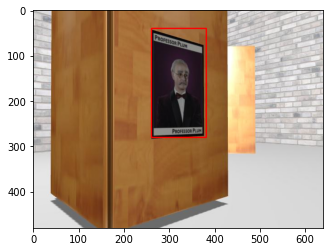

In [126]:
image_number = 20

image = img_arr[image_number]
box = bboxes[image_number]
label = class_labels=[image_number]


transformed = transform(image=image, bboxes=box, class_labels=label)

transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']


annot_image, box_areas = draw_boxes(
    transformed_image, transformed_bboxes
)

img = cv2.cvtColor(annot_image, cv2.COLOR_BGR2RGB)


plt.imshow(img)